In [40]:
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

## (Self-Corrective) RAG on LangGraph
https://github.com/vbarda/pandas-rag-langgraph/blob/main/demo.ipynb

- RAG（Retrieval-Augmented Generation）
  - 未被 llm 训练过程覆盖的 domain knowledge 或者新知识；
  - 提供确定性的知识作为 context，进一步降低幻觉（hallucinations）
    - GROUNDED IN DOCUMENTS
- vector database
  - Chroma
### RAG chain: developer-defined control flow

In [2]:

Image(url='./imgs/rag-chain.png', width=500)

In [3]:
Image(url='./imgs/rag-agent.png', width=500)

In [4]:
Image(url='./imgs/self-corrective-rag.png', width=500)

In [5]:
import re
from typing import Annotated, Iterator, Literal, TypedDict

from langchain import hub

# llm
# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

# tool, 
# https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/
# TAVILY_API_KEY
from langchain_community.tools.tavily_search import TavilySearchResults

# rag
from langchain_community.document_loaders import web_base
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_core.retrievers import BaseRetriever

# messages & prompts
from langchain_core.messages import BaseMessage, AIMessage, convert_to_messages
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_text_splitters import RecursiveCharacterTextSplitter

# langgraph
from langgraph.graph import END, StateGraph, add_messages

from langgraph.checkpoint.memory import MemorySaver

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Users\huang\anaconda3\envs\llm_env\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
import os
os.environ["ALL_PROXY"] = "socks5://127.0.0.1:33211"
os.environ["HTTP_PROXY"] = "http://127.0.0.1:33210"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:33210"
os.environ["USER_AGENT"] = "my-llm-app/0.1"
from dotenv import load_dotenv
load_dotenv()

True

### model, retriever & tools

In [7]:
SOURCE_URLS = [
    'https://pandas.pydata.org/docs/user_guide/indexing.html',
    'https://pandas.pydata.org/docs/user_guide/groupby.html',
    'https://pandas.pydata.org/docs/user_guide/merging.html'
]
NEWLINE_RE = re.compile("\n+")

In [8]:
class PandasDocsLoader(web_base.WebBaseLoader):
    def lazy_load(self) -> Iterator[Document]:
        """Lazy load text from the url(s) in web_path."""
        for path in self.web_paths:
            soup = self._scrape(path, bs_kwargs=self.bs_kwargs)
            text = soup.get_text(**self.bs_get_text_kwargs)
            text = NEWLINE_RE.sub("\n", text)     
            metadata = web_base._build_metadata(soup, path)
            yield Document(page_content=text, metadata=metadata)

In [9]:
PandasDocsLoader(SOURCE_URLS).web_paths

['https://pandas.pydata.org/docs/user_guide/indexing.html',
 'https://pandas.pydata.org/docs/user_guide/groupby.html',
 'https://pandas.pydata.org/docs/user_guide/merging.html']

In [10]:
def prepare_documents(urls: list[str]) -> list[Document]:
    text_splitter = RecursiveCharacterTextSplitter(
        separators=[
            r"In \[[0-9]+\]",
            r"\n+",
            r"\s+"
        ],
        is_separator_regex=True,
        chunk_size=1000
    )
    docs = [PandasDocsLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]
    return text_splitter.split_documents(docs_list)

In [11]:
def get_retriever() -> BaseRetriever:
    documents = prepare_documents(SOURCE_URLS)
    vectorstore = Chroma.from_documents(
        documents=documents,
        collection_name="pandas-rag-chroma",
        embedding=OpenAIEmbeddings(),
    )
    retriever = vectorstore.as_retriever()
    return retriever

In [12]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)
retriever = get_retriever()
tavily_search_tool = TavilySearchResults(max_results=3)

### Graph

In [13]:
Image(url='./imgs/self-corrective-rag.png', width=500)

- state: graph 中所有 node 的输入
  - question: user query
  - messages: add
  - documents: 基于 retriever.invoke(question) or search_tool
  - candidate_answer: generate
  - retries
  - web_fallback
- nodes: 接收状态，执行动作，产生/改变状态
  - rewrite question: 单独的一个重写用户 query 的 llm 调用
  - document_search: retriever
    - append documents
  - generate: llm chain (lcel)
    - 提供或者替换 candidate_answer
  - web search: search tool
    - append documents
  - finalize response

### state

In [14]:
class GraphState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    question: str
    documents: list[Document]
    candidate_answer: str
    retries: int
    web_fallback: bool


class GraphConfig(TypedDict):
    max_retries: int

In [15]:
MAX_RETRIES = 3
VERBOSE = True

### nodes

document search node

In [16]:
def document_search(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if VERBOSE:
        print("---RETRIEVE---")

    question = convert_to_messages(state["messages"])[-1].content

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "web_fallback": True}

In [17]:
# https://smith.langchain.com/hub/rlm/rag-prompt
# RAG: QA with context, answer the question base the context
RAG_PROMPT: ChatPromptTemplate = hub.pull("rlm/rag-prompt")
RAG_PROMPT

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

### generate node

In [18]:
def generate(state: GraphState):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if VERBOSE:
        print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    retries = state["retries"] if state.get("retries") is not None else -1

    # lcel
    rag_chain = RAG_PROMPT | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"retries": retries + 1, "candidate_answer": generation}

### rewrite question

In [20]:
QUERY_REWRITER_SYSTEM = (
"""
You are a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval.
Look at the input and try to reason about the underlying semantic intent / meaning.
"""
)

QUERY_REWRITER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", QUERY_REWRITER_SYSTEM),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [26]:
def transform_query(state: GraphState):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    if VERBOSE:
        print("---TRANSFORM QUERY---")

    question = state["question"]

    # Re-write question
    query_rewriter = QUERY_REWRITER_PROMPT | llm | StrOutputParser()
    better_question = query_rewriter.invoke({"question": question})
    return {"question": better_question}

### web search

In [21]:
def web_search(state: GraphState):
    if VERBOSE:
        print("---RUNNING WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]
    search_results = tavily_search_tool.invoke(question)
    search_content = "\n".join([d["content"] for d in search_results])
    documents.append(Document(page_content=search_content, metadata={"source": "websearch"}))
    return {"documents": documents, "web_fallback": False}

### finalize response

In [22]:
def finalize_response(state: GraphState):
    if VERBOSE:
        print("---FINALIZING THE RESPONSE---")

    return {"messages": [AIMessage(content=state["candidate_answer"])]}

### edges & graph

In [23]:
Image(url='./imgs/self-corrective-rag.png', width=500)

Grade answer
- Check hallucinations
- Check answer relevance

In [35]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


HALLUCINATION_GRADER_SYSTEM = (
"""
You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Give a binary score 'yes' or 'no', where 'yes' means that the answer is grounded in / supported by the set of facts.

IF the generation includes code examples, make sure those examples are FULLY present in the set of facts, otherwise always return score 'no'.
"""
)

HALLUCINATION_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", HALLUCINATION_GRADER_SYSTEM),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)


class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


ANSWER_GRADER_SYSTEM = (
"""
You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no', where 'yes' means that the answer resolves the question.
"""
)

ANSWER_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", ANSWER_GRADER_SYSTEM),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [36]:
def grade_generation_v_documents_and_question(state: GraphState, config) -> Literal["generate", "transform_query", "web_search", "finalize_response"]:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["candidate_answer"]
    web_fallback = state["web_fallback"]
    retries = state["retries"] if state.get("retries") is not None else -1
    max_retries = config.get("configurable", {}).get("max_retries", MAX_RETRIES)

    # this means we've already gone through web fallback and can return to the user
    if not web_fallback:
        return "finalize_response"
    if VERBOSE:
        print("---CHECK HALLUCINATIONS---")

    # llm lcel chain
    hallucination_grader = HALLUCINATION_GRADER_PROMPT | llm.with_structured_output(GradeHallucinations)
    hallucination_grade: GradeHallucinations = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    # Check hallucination
    if hallucination_grade.binary_score == "no":
        if VERBOSE: print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "generate" if retries < max_retries else "web_search"

    if VERBOSE:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")

    # Check question-answering
    answer_grader = ANSWER_GRADER_PROMPT | llm.with_structured_output(GradeAnswer)
    answer_grade: GradeAnswer = answer_grader.invoke({"question": question, "generation": generation})
    if answer_grade.binary_score == "yes":
        if VERBOSE: print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "finalize_response"
    else:
        if VERBOSE: print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "transform_query" if retries < max_retries else "web_search"

条件性跳转（from `generate`），基于的幻觉检测（llm lcel chain invoke）

- "generate",
- "transform_query",
- "web_search",
- "finalize_response"

### build the graph

In [37]:
workflow = StateGraph(GraphState, config_schema=GraphConfig)

# Define the nodes
workflow.add_node("document_search", document_search)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)
workflow.add_node("finalize_response", finalize_response)

# Build graph
workflow.set_entry_point("document_search")
workflow.add_edge("document_search", "generate")
workflow.add_edge("transform_query", "document_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("finalize_response", END)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question
)

# Compile
graph = workflow.compile()

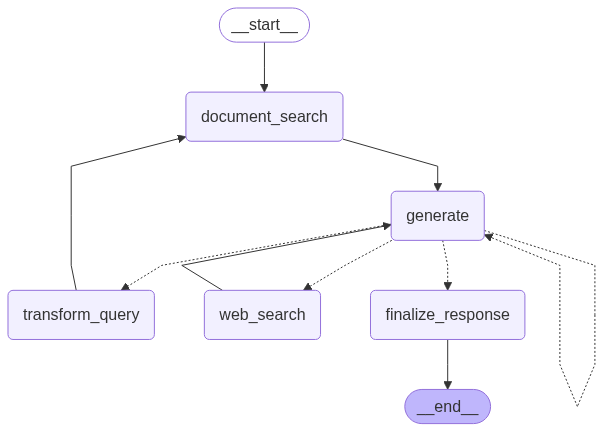

In [38]:
from IPython.display import Image, display
# grade_generation_v_documents_and_question
display(Image(graph.get_graph().draw_mermaid_png()))

### run the graph

In [41]:
VERBOSE = True
inputs = {"messages": [("human", "how do i calculate sum by groups")]}
for output in graph.stream(inputs):
    print(output)
    print("\n---\n")

---RETRIEVE---
{'document_search': {'question': 'how do i calculate sum by groups', 'documents': [Document(metadata={'source': 'https://pandas.pydata.org/docs/user_guide/groupby.html', 'language': 'en', 'title': 'Group by: split-apply-combine — pandas 2.3.2 documentation'}, page_content='By “group by” we are referring to a process involving one or more of the following\nsteps:\nSplitting the data into groups based on some criteria.\nApplying a function to each group independently.\nCombining the results into a data structure.\nOut of these, the split step is the most straightforward. In the apply step, we\nmight wish to do one of the following:\nAggregation: compute a summary statistic (or statistics) for each\ngroup. Some examples:\nCompute group sums or means.\nCompute group sizes / counts.\nTransformation: perform some group-specific computations and return a\nlike-indexed object. Some examples:\nStandardize data (zscore) within a group.\nFilling NAs within groups with a value deriv

### Query with a fallback

In [42]:
VERBOSE = True
inputs = {"messages": [("human", "how do i convert a column into dummies")]}
for output in graph.stream(inputs, {"configurable": {"max_retries": 1}}):
    print(output)
    print("\n---\n")

---RETRIEVE---
{'document_search': {'question': 'how do i convert a column into dummies', 'documents': [Document(metadata={'language': 'en', 'title': 'Group by: split-apply-combine — pandas 2.3.2 documentation', 'source': 'https://pandas.pydata.org/docs/user_guide/groupby.html'}, page_content='naturally to multiple columns of mixed type and different\nsources. This can be useful as an intermediate categorical-like step\nin processing, when the relationships between the group rows are more\nimportant than their content, or as input to an algorithm which only\naccepts the integer encoding. (For more information about support in\npandas for full categorical data, see the Categorical\nintroduction and the\nAPI documentation.)'), Document(metadata={'title': 'Indexing and selecting data — pandas 2.3.2 documentation', 'language': 'en', 'source': 'https://pandas.pydata.org/docs/user_guide/indexing.html'}, page_content="In [25]: sa.a = 5\nIn [26]: sa\nOut[26]: \na    5\nb    2\nc    3\ndtype: i

In [43]:
graph.invoke(inputs)

---RETRIEVE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---RUNNING WEB SEARCH---
---GENERATE---
---FINALIZING THE RESPONSE---


{'messages': [HumanMessage(content='how do i convert a column into dummies', additional_kwargs={}, response_metadata={}, id='0a70ee4f-9152-4f6f-921b-202d645f501f'),
  AIMessage(content="To convert a column into dummy variables in pandas, you can use the `get_dummies()` function. This function automatically converts categorical columns into dummy/indicator variables. For example, `pd.get_dummies(df['column_name'])` will create a new DataFrame with dummy variables for each category in the specified column.", additional_kwargs={}, response_metadata={}, id='589a4b47-7d41-438a-a69b-f85fc2342295')],
 'question': 'how do i convert a column into dummies',
 'documents': [Document(metadata={'source': 'https://pandas.pydata.org/docs/user_guide/groupby.html', 'title': 'Group by: split-apply-combine — pandas 2.3.2 documentation', 'language': 'en'}, page_content='naturally to multiple columns of mixed type and different\nsources. This can be useful as an intermediate categorical-like step\nin proces